## Perform linear regression calculations from first principles

Output: Lightweight module to perform all relevant linear regression calculations:
1. Linear Regression Assumption Diagnostics
2. Implement Data Transformations to correct for assumptions
3. Calculation of Linear Coefficients and Correlation
4. Calculating Standard Error of the Regression, Mean, Forecast, Linear Coefficients
5. Plot Charts representing prediction and Confidence Intervals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

Args and Kwargs --> allows function to take variable length arguments
1. Args: Non-Keyward Argument --> just adding any variables
2. Kwargs: Keyword Argument --> adding variables that are named using keywords

In [2]:
# create a linear regression class, that after pushing in 2 lists, generates all linear regression statistics
class LinearReg:
    # create a class to generate and store all linear regression variables, based on inputs x and y
    
    # initiate constructor of the class
    def __init__(self, x: list, y: list, x_label: str = 'x', y_label: str = 'y', log_y: bool = False):
        # set whether to log or not
        self.log_y = log_y
        
        # if we choose to log y
        if self.log_y == True:
            y = np.log(y)
        else:
            pass
        
        # store x and y in a dataframe and extract reusable variables
        self.df = pd.DataFrame(list(zip(x, y)), columns=['x', 'y'])
        self.mean_x, self.mean_y = self.df['x'].mean(), self.df['y'].mean()
        self.std_x, self.std_y = self.df['x'].std(), self.df['y'].std()
        self.n = len(self.df)
        
        # generate standardised values
        self.df['standard_x'] = (self.df['x'] - self.mean_x) / self.std_x
        self.df['standard_y'] = (self.df['y'] - self.mean_y) / self.std_y

        # generate correlation coefficient from first principles: average product of standardised values of x and y
        # Note we can also use the correlation coefficient
        self.corr = sum(self.df.standard_x * self.df.standard_y) / self.n
        self.r_squared = self.corr ** 2
        self.adj_r_squared = 1 - (((self.n - 1)/(self.n - 2)) * (1 - self.r_squared))
        
        # generate linear coefficients
        self.b1 = self.corr * self.std_y / self.std_x
        self.b0 = self.mean_y - self.b1 * self.mean_x
        
        # generate errors in df
        self.df['lin_y'] = self.b0 + self.b1 * self.df.x
        self.df['err'] = self.df.y - self.df.lin_y
        self.rmse = np.sqrt((self.df.err ** 2).sum() / self.n)
        
        # save se_reg
        self.se_reg = np.sqrt(1/(self.n-2) * sum(self.df.err**2))
        
    # generate prediction
    def get_prediction(self, x) -> float:
        prediction = self.b0 + self.b1 * x
        return prediction
        
    # calculate standard errors of coefficients and the regression
    def update_coefficient_standard_errors(self):        
        # standard error of the linear coefficients
        self.se_b1 = (self.se_reg / (self.n**0.5)) * (1 + ((self.mean_x ** 2) / self.std_x **2)) ** 0.5
        self.se_b0 = (self.se_reg / (self.n**0.5)) * (1 / self.std_x)
        output = {'SE Regression': round(self.se_reg, 3),
                  'SE B0': round(self.se_b0, 3),
                  'SE B1': round(self.se_b1, 3)
                 }
        return output
    
    # get standard error of a single observation
    def get_standard_errors(self, x: int) -> dict:
        self.update_coefficient_standard_errors()
        se_mean = (self.se_reg / (self.n ** 0.5)) * np.sqrt((x - self.mean_x) ** 2 / (self.std_x ** 2))
        se_forecast = np.sqrt(self.se_reg ** 2 + se_mean ** 2)
        # return dictionary of results
        return {'se_mean': se_mean, 'se_forecast': se_forecast}
    
    # plot confidence intervals based on regression
    def get_confidence_interval(self, x, confidence_level: int = 0.95) -> float:
        # using standard error of the forecast, calculate confidence intervals - 95% CI
        alpha = 1 - (1 - confidence_level)/2
        critical_t_value = st.norm.ppf(alpha)
        confidence_interval = critical_t_value * self.get_standard_errors(x)['se_forecast']
        return confidence_interval
        
    # perform checks on linearity and homoscedasticity
    def assumption_checks(self, fig_size: tuple = (10, 10), size: int = 5):
        # lay out plot figure
        figure = plt.figure(figsize=fig_size)
        
        # construct plots to check for independence of erros
        # residuals against independent values
        residual_x_plot = figure.add_subplot(221)
        residual_x_plot.scatter(self.df.x, self.df.err, s=size)
        plt.axhline(0, color='red')
        plt.axvline(0, color='red')        
        plt.ylabel('Error')
        plt.xlabel('x')
        plt.title('Checking for Independence of Errors')
        
        # construct plots to check for linearity and homoscedasticity
        # residuals against predicted values
        residual_liny_plot = figure.add_subplot(222)
        residual_liny_plot.scatter(self.df.lin_y, self.df.err, s=size)
        plt.axhline(0, color='red')        
        plt.ylabel('Error')
        plt.xlabel('Prediction')
        plt.title('Checking for Linearity')
        
        # construct plots to check for homoscedasticity - scale-location plot
        # squared residual against predicted values
        residual_liny_plot = figure.add_subplot(223)
        # plot root of standardised residual over predicted values
        residual_liny_plot.scatter(self.df.lin_y, ((self.df.err - self.df.err.mean()) / self.df.err.std()) ** 0.5, s=size)
        plt.ylabel('Squareroot of Standardised Residual')
        plt.xlabel('Prediction')        
        plt.title('Checking for Homoscedasticity: Scale-Location Plot')
        
        # construct QQ plot to check for normality of errors
        qqplot_df = self.generate_qq_plot()
        residual_qq_plot = figure.add_subplot(224)
        residual_qq_plot.scatter(qqplot_df.theoretical_err, qqplot_df.err, s=size)
        plt.title('Checking for Normality of Errors: QQPlot')
        plt.ylabel('Normal Data Quantiles')
        plt.xlabel('Normal Theoretical Quantiles')
        
        plt.show()
        
        # print checks
        print("Assumption Checks:\nIndependence of Errors: Residuals should be randomly and symmetrically distributed around zero under all conditions\nLinearity: The points should be symmetrically distributed around a horizontal line, with roughly constant variance.\nHomoscedasticity: Check for patterns in residuals - they should not systematically get larger/smaller.\nNormality of Error Distribution: Check if points in QQPlot fall close to diagonal reference line.")
        
        # Statistical Tests for Independence of Errors: Durbin Watson Test
        db_result = round(durbin_watson(self.df.err), 3)
        print('Performing Durbin Watson Test to check for Independence of Errors...')
        if (db_result >= 1.5 and db_result <= 2.5):
            db_bool = 'not correlated'
        else:
            db_bool = 'correlated'
        print(f'Durbin Watson: {db_result}; the errors are {db_bool}.')    
        
        
    # obtain quantile-quantile-plot from first principles, using error
    # to check for normality of errors
    def generate_qq_plot(self):
        # compare the real distribution of the errors with a normal distribution
        err_mean = self.df.err.mean()
        err_std = self.df.err.std()
        new_df = self.df
        
        # generate new column of hypothetical percentiles
        new_df['err_percentile'] = st.percentileofscore(new_df.err, new_df.err)  # obtain percentile
        new_df['theoretical_err'] = (st.norm.ppf(new_df['err_percentile']/100) * err_std) + err_mean # obtain new figure based on percentile
        return new_df
        
    # perform first scatter plot of raw data and linear predictions
    def plot_basic(self):
        plt.figure(figsize=(7, 5))
        plt.scatter(self.df.x, self.df.y, color='b', s=2)
        plt.plot(self.df.x, self.df.lin_y, color='r')
        plt.title('Raw Data with first Linear Prediction')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
    
    # linear regression plot with confidence intervals
    def linear_reg_plot(self, interval: int = 1, confidence_level: float = 0.95, xmin: float = None, xmax: float = None):      
        # if information not provided
        if not xmin:
            xmin = self.df.x.min()
        if not xmax:
            xmax = self.df.x.max()

        # generate ranges
        self.x_range = range(xmin, xmax, interval)
        self.prediction = [model.get_prediction(x) for x in self.x_range]
        self.confidence_intervals = [self.get_confidence_interval(x, confidence_level) for x in self.x_range]
        self.lower_bound = np.array(self.prediction) - np.array(self.confidence_intervals)
        self.upper_bound = np.array(self.prediction) + np.array(self.confidence_intervals)
        
        # only in the log_y case, plot the transformed prediction
        if self.log_y == True:
            # generate linear regression plot
            fig = plt.figure(figsize=(15, 6))
            log_plot = fig.add_subplot(121)
            log_plot.plot(self.x_range, self.prediction, color='r')
            log_plot.fill_between(self.x_range, self.lower_bound, self.upper_bound, color='antiquewhite')
            log_plot.scatter(self.df.x, self.df.y, s=4)
            plt.title(f'Log Linear Regression Predictions with {confidence_level * 100}% Confidence Interval')
            plt.xlabel('x')
            plt.ylabel('log y')
            
            # transformed plot
            normal_plot = fig.add_subplot(122)
            normal_plot.plot(self.x_range, np.exp(self.prediction), color='r')
            normal_plot.fill_between(self.x_range, np.exp(self.lower_bound), np.exp(self.upper_bound), color='antiquewhite')
            normal_plot.scatter(self.df.x, np.exp(self.df.y), s=4)
            plt.title(f'Reverted Linear Regression Predictions with {confidence_level * 100}% Confidence Interval')
            plt.xlabel('x')
            plt.ylabel('y')
            
        else:
            # generate linear regression plot
            fig = plt.figure(figsize=(6, 6))
            plt.plot(self.x_range, self.prediction, color='r')
            plt.fill_between(self.x_range, self.lower_bound, self.upper_bound, color='antiquewhite')
            plt.scatter(self.df.x, self.df.y, s=4)
            plt.title(f'Linear Regression Predictions with {confidence_level * 100}% Confidence Interval')
            plt.xlabel('x')
            plt.ylabel('y')
            
        plt.show()
        
    # overall summary of regression analysis
    def linear_reg_summary(self, confidence_level: float = 0.95):
        # perform assumption checks
        self.assumption_checks()
        print('\n')
        # obtain parameters
        dp = 4
        output_dict = self.update_coefficient_standard_errors()
        output_dict['b0'] = round(self.b0, dp)
        output_dict['b1'] = round(self.b1, dp)
        output_dict['Correlation'] = round(self.corr, dp)
        output_dict['R-Squared'] = round(self.r_squared, dp)
        output_dict['Adjusted R-Squared'] = round(self.adj_r_squared, dp)
        output_dict['RMSE'] = round(self.rmse, dp)
        output_dict['b0 Standard Error'] = round(output_dict.pop('SE B0'), dp)
        output_dict['b1 Standard Error'] = round(output_dict.pop('SE B1'), dp)
        output_dict['Regression Standard Error'] = output_dict.pop('SE Regression')
        self.output_dict = output_dict
        print('Generating LinReg Parameters...')
        # convert to dataframe and print results
        output_df = pd.DataFrame.from_dict(self.output_dict, orient='index').rename(columns={0: 'Value'})
        print(output_df)
        
        # Perform linear regression, with confidence intervals
        self.linear_reg_plot(confidence_level=confidence_level)
        print('Linear Regression Analysis Completed')

In [3]:
# import relevant datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# remove non-numerical columns
train_df = train_df.loc[:, train_df.dtypes != 'object']

In [4]:
train_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [5]:
# choose relevant columns
x = list(train_df['LotArea'])
y = list(train_df['SalePrice'])

In [9]:
# initialise class
model = LinearReg(x, y, log_y=False)

In [10]:
model.df

,x,y,standard_x,standard_y,lin_y,err
0,8450,208500,-0.207071,0.347154,176583.887684,31916.112316
1,9600,181500,-0.091855,0.007286,178997.201341,2502.798659
2,11250,223500,0.073455,0.535970,182459.781805,41040.218195
3,9550,140000,-0.096864,-0.515105,178892.274660,-38892.274660
4,14260,250000,0.375020,0.869545,188776.367986,61223.632014
...,...,...,...,...,...,...
1455,7917,175000,-0.260471,-0.074534,175465.369267,-465.369267
1456,13175,210000,0.266316,0.366036,186499.459014,23500.540986
1457,9042,266500,-0.147760,1.077242,177826.219584,88673.780416
1458,9717,142125,-0.080133,-0.488356,179242.729774,-37117.729774


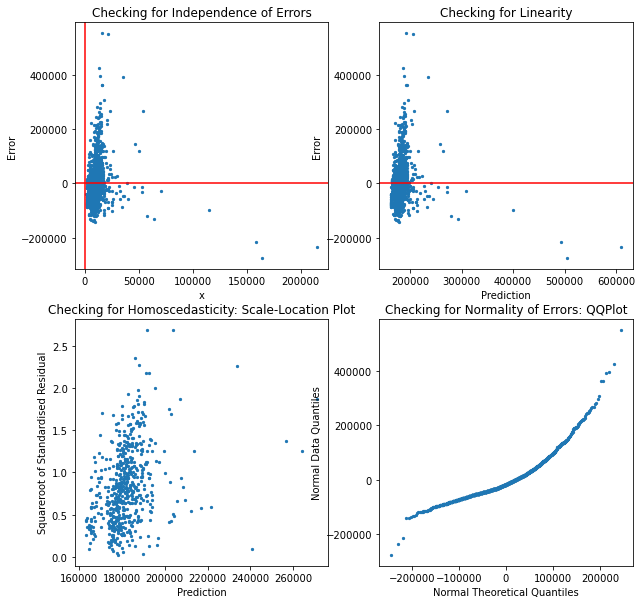

Assumption Checks:
Independence of Errors: Residuals should be randomly and symmetrically distributed around zero under all conditions
Linearity: The points should be symmetrically distributed around a horizontal line, with roughly constant variance.
Homoscedasticity: Check for patterns in residuals - they should not systematically get larger/smaller.
Normality of Error Distribution: Check if points in QQPlot fall close to diagonal reference line.
Performing Durbin Watson Test to check for Independence of Errors...
Durbin Watson: 1.998; the errors are not correlated.


Generating LinReg Parameters...
                                 Value
b0                         158851.2786
b1                              2.0985
Correlation                     0.2637
R-Squared                       0.0695
Adjusted R-Squared              0.0689
RMSE                        76601.2554
b0 Standard Error               0.2010
b1 Standard Error            2914.1920
Regression Standard Error   76653.7760


In [ ]:
model.linear_reg_summary()